In [1]:
import tensorflow as tf
import glob
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, LeakyReLU, Conv2D as conv2D, Dropout, Add, UpSampling2D, concatenate
import cv2
import random
import os
import PIL
from PIL import Image, ImageOps
from matplotlib import colors, cm



HEIGHT = 256
WIDTH = 256
TRAIN_SIZE = 1815
TEST_SIZE = 389
VALI_SIZE = 389

In [2]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, LeakyReLU, Conv2D as conv2D, Dropout, Add, UpSampling2D, concatenate


def improved_unet(W, H):
    input_size = (W, H, 3)
    inputs = Input(input_size)
    print(inputs)
    #W*H*16
    conv1 = conv2D(16, 3, activation = tf.keras.layers.LeakyReLU(alpha=0.01), padding = 'same')(inputs)
    cont1 = conv2D(16, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv1)
    cont1 = Dropout(0.5)(cont1)
    cont1 = conv2D(16, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont1)
    conc1 = Add()([conv1, cont1]) #W*H*16
    # W/2 * H/2 * 32
  
    conv2 = conv2D(32, 3, strides = (2,2), activation = LeakyReLU(alpha=0.01), padding = 'same')(conc1)
    cont2 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv2)
    cont2 = Dropout(0.5)(cont2)
    cont2 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont2)
    conc2 = Add()([conv2, cont2]) #W/2*H/2*32

    conv3 = conv2D(64, 3, strides = (2,2), activation = LeakyReLU(alpha=0.01), padding = 'same')(conc2)
    cont3 = conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv3)
    cont3 = Dropout(0.4)(cont3)
    cont3 = conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont3)
    conc3 = Add()([conv3, cont3]) #W/4*H/4*64

    conv4 = conv2D(128, 3, strides = (2,2), activation = LeakyReLU(alpha=0.01), padding = 'same')(conc3)
    cont4 = conv2D(128, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv4)
    cont4 = Dropout(0.4)(cont4)
    cont4 = conv2D(128, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont4)
    conc4 = Add()([conv4, cont4]) #W/8*H/8*128
 
    conv5 = conv2D(256, 3, strides = (2,2), activation = LeakyReLU(alpha=0.01), padding = 'same')(conc4)
    cont5 = conv2D(256, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv5)
    cont5 = Dropout(0.4)(cont5)
    cont5 = conv2D(256, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont5)
    conc5 = Add()([conv5, cont5]) #W/16*H/16*256

    uconv5 = UpSampling2D(size = (2,2))(conc5)
    uconv5 = conv2D(128, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv5)
 
    uconv4 = concatenate([uconv5, conc4])
    lconv4 = conv2D(128, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv4)
    lconv4 = conv2D(128, 1, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv4)
    uconv4 = UpSampling2D(size = (2,2))(uconv4)
    uconv4 = Dropout(0.4)(uconv4)
    uconv4 = conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv4)
     
    
    uconv3 = concatenate([uconv4, conc3])
    lconv3 = conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv3)
    lconv3 = conv2D(64, 1, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv3)
    uconv3 = UpSampling2D(size = (2,2))(lconv3)
    uconv3 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv3)

    uconv2 = concatenate([uconv3, conc2])   
    lconv2 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv2)
    lconv2 = conv2D(32, 1, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv2)
    
   
    uconv2 = UpSampling2D(size = (2,2))(uconv2)
    uconv2 = conv2D(16, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv2)
    
    uconv1 = concatenate([uconv2, conc1])
    uconv1 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv1)
    
    sconv3 = conv2D(1, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv3)
    sconv3 = UpSampling2D(size = (2,2))(sconv3) 
    sconv2 = conv2D(1, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv2) 
    usconv2 = Add()([sconv2, sconv3])
    usconv2 = UpSampling2D(size = (2,2))(usconv2) 
    sconv1 = conv2D(1, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv1) 
    sconv1 = Add()([sconv1, usconv2])
    output = conv2D(1, 1, activation = 'sigmoid')(sconv1)
    model = Model(inputs = inputs, outputs = output)
    return model


In [3]:
def dice_coef(predictions, truth, axis=(1,2,3)):
    predictions = tf.convert_to_tensor(predictions, np.float32)
    truth = tf.convert_to_tensor(truth, np.float32)
    numerator = (2.0 * (tf.reduce_sum(predictions * truth, axis=axis))) + 1
    denominator = tf.reduce_sum(predictions, axis=axis) + tf.reduce_sum(truth, axis=axis) + 1
    coef = tf.reduce_mean(numerator / denominator)
    return coef

def dice_coef_loss(predictions, truth):
    return 1 - dice_coef(predictions, truth)


def read_images(image_file, mask_file):
    img = cv2.imread(image_file)
    img = cv2.resize(img, (HEIGHT, WIDTH))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255
    img = (img - img.mean())/img.std()
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (HEIGHT, WIDTH))
    mask = np.round(mask/255)
    mask = mask[:, :, np.newaxis]
    return img, mask

    
def image_generator(image_fnames, mask_fnames, batchsize):
    count = len(image_fnames)
    while True:
        random_indices = random.sample(range(count), batchsize)
        batch_img, batch_mask = [], []
        for index in random_indices:
            img, mask = read_images(image_fnames[index], mask_fnames[index])
            batch_img.append(img)
            batch_mask.append(mask)
        images = np.stack(batch_img, axis=0)
        masks = np.stack(batch_mask, axis=0)
        yield images, masks 
        
def plot_gen(data_gen):
    images, masks = next(data_gen)
    plot_images(images, 3)
    plot_images(masks, 1)

def plot_images(images, dim):
    fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15,15))
    for i in range(5):
        if dim == 3:
            img = images[i, :, :, :]
            norm = colors.LogNorm(img.mean() + 0.5 * img.std(), img.max(), clip='True')  
            axs[i].imshow(img, cmap=cm.gray, norm=norm, origin="lower")
        elif dim == 1:
            img = images[i, :, :, 0]
            axs[i].imshow(img, cmap='gray')
    plt.show()
    

def check_loaded(train_gen, test_gen, val_gen):
    plot_gen(train_gen)
    plot_gen(test_gen)
    plot_gen(val_gen)
        
def plot_comparison(images, test_masks, predictions):
    images, test_masks, predictions = generate_random_images(images, test_masks, predictions)
    plot_images(images, 3)
    plot_images(test_masks, 1)    
    plot_images(predictions, 1)

def generate_random_images(test_images, test_masks, predictions):
    random_indices = random.sample(range(TEST_SIZE), 5)
    print(random_indices)
    imgs = []
    preds = []
    masks = []
    for i in random_indices:
        imgs.append(test_images[i, :, :, :])
        masks.append(test_masks[i, :, :, :])
        preds.append(predictions[i, :, :, :])
    imgs = np.stack(imgs, axis=0)
    masks = np.stack(masks, axis=0)
    preds = np.stack(preds, axis=0)
    return imgs, masks, preds

def load_images_from_fn(image_fnames, mask_fnames):
    images = []
    masks = []
    for i in range(len(image_fnames)):
        img, mask = read_images(image_fnames[i], mask_fnames[i])
        images.append(img)
        masks.append(mask)
    images = np.stack(images, axis=0)
    masks = np.stack(masks, axis=0)
    return images, masks


def load_original_test_images(test_x):
    images = []
    for file in test_x:
        img = PIL.Image.open(str(file))
        img = ImageOps.flip(img)
        img = img.resize((HEIGHT, WIDTH))
        img = np.array(img.getdata()).reshape(HEIGHT, WIDTH, 3)
        images.append(img)
    images = np.stack(images, axis=0)
    return images

def read_images(image_file, mask_file):
    img = cv2.imread(image_file)
    img = cv2.resize(img, (HEIGHT, WIDTH))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255
    img = (img - img.mean())/img.std()
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (HEIGHT, WIDTH))
    mask = np.round(mask/255)
    mask = mask[:, :, np.newaxis]
    return img, mask


In [4]:
def load_data():
    input_images = sorted(glob.glob("H:\\COMP3710/report/ISIC2018_Task1-2_Training_Data/input/*.jpg"))
    output_masks = sorted(glob.glob("H:\\COMP3710/report/ISIC2018_Task1-2_Training_Data/truth/*.png"))
    
    # Separate file names to train, validation and test.
    DATASET_SIZE = len(input_images)
    train_size = int(DATASET_SIZE * 0.7)
    val_size = test_size = int(DATASET_SIZE * 0.15)
    train_x = input_images[0:train_size]
    train_y = output_masks[0:train_size]
    test_x = input_images[train_size:train_size+test_size]
    test_y = output_masks[train_size:train_size+test_size]
    val_x = input_images[train_size+test_size:]
    val_y = output_masks[train_size+test_size:]
    
    train_gen = image_generator(train_x, train_y, 10)
    val_gen = image_generator(val_x, val_y, 10)
    test_images, test_masks = load_images_from_fn(test_x, test_y)
    test_images_forplot = load_original_test_images(test_x)
    print('Loading success')
    return train_gen, val_gen, test_masks, test_images, test_images_forplot


def compile_model(train_gen, val_gen):
    model = improved_unet(HEIGHT, WIDTH)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, 'acc'])
    # Create check point
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='acc',
        mode='max',
        save_best_only=True)
    # Compile model
    train_history = model.fit(train_gen, epochs=250, steps_per_epoch=10, validation_data = val_gen, validation_steps=10)
    return model, train_history

def plot_training_results(train_history):
    plt.plot(train_history.history['loss'], 'k', label='Training loss')
    plt.plot(train_history.history['val_loss'], 'b', label = 'Validation loss')
    plt.title('Loss of trained data')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.figure()
    plt.plot(train_history.history['acc'], 'k', label='Training accuracy')
    plt.plot(train_history.history['val_acc'], 'b', label='Validation accuracy')
    plt.title('Accuracy of trained data')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.figure()
    plt.plot(train_history.history['dice_coef'], 'k', label='Training dsc ')
    plt.plot(train_history.history['val_dice_coef'], 'b', label='Validation dsc')
    plt.title('Dice similarity coefficient of trained data')
    plt.xlabel('Iterations')
    plt.ylabel('Dice similarity coefficient')
    plt.legend()
    plt.grid()


In [5]:
train_gen, val_gen, test_masks, test_images, test_images_forplot = load_data()

Loading success


In [6]:
model, train_history = compile_model(train_gen, val_gen)

Tensor("input_1:0", shape=(None, 256, 256, 3), dtype=float32)
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 10 steps
Epoch 1/10
10/10 [==============================] - 21s 2s/step - loss: 0.7340 - dice_coef: 0.2550 - acc: 0.3675 - val_loss: 0.6849 - val_dice_coef: 0.3057 - val_acc: 0.7684
Epoch 2/10
10/10 [==============================] - 18s 2s/step - loss: 0.6783 - dice_coef: 0.2638 - acc: 0.7087 - val_loss: 0.6630 - val_dice_coef: 0.3044 - val_acc: 0.8393
Epoch 3/10
10/10 [==============================] - 17s 2s/step - loss: 0.6335 - dice_coef: 0.2602 - acc: 0.7983 - val_loss: 0.5657 - val_dice_coef: 0.3014 - val_acc: 0.8212
Epoch 4/10
10/10 [==============================] - 14s 1s/step - loss: 0.5591 - dice_coef: 0.1648 - acc: 0.7756 - val_loss: 0.5374 - val_dice_coef: 0.2853 - val_acc: 0.7847
Epoch 5/10
10/10 [==============================] - 16s 2s/step - loss: 0.4957 - dice_coef: 0.2432 - acc: 0.8049 - val_loss: 0.5048 - val_dice_coef: 0

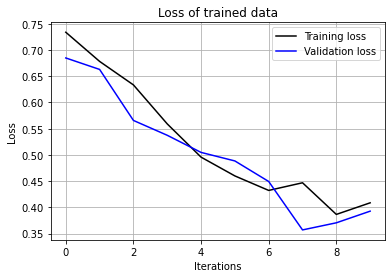

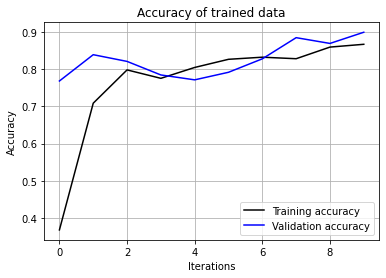

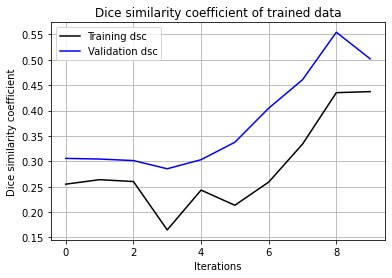

In [7]:
plot_training_results(train_history)

In [8]:
predictions = np.round(model.predict(test_images))

[220, 28, 114, 33, 323]


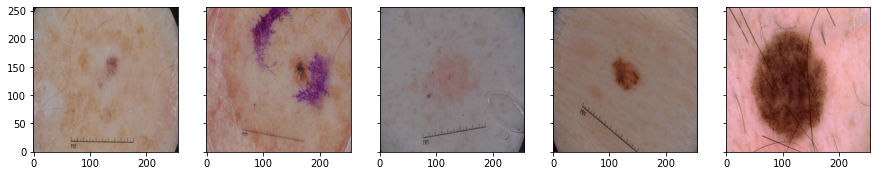

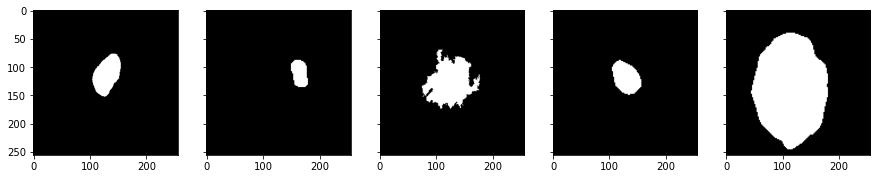

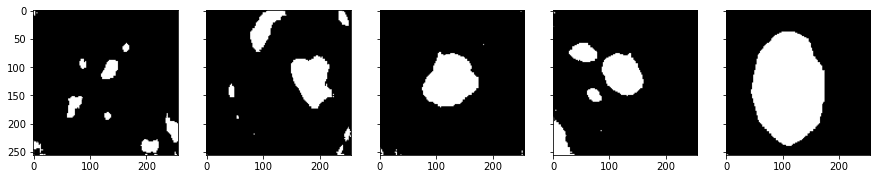

In [9]:
plot_comparison(test_images_forplot, test_masks, predictions)

In [10]:
dsc = dice_coef(predictions, test_masks)
print('Dice similarity coefficient: ' + str(dsc))

Dice similarity coefficient: tf.Tensor(0.6273926, shape=(), dtype=float32)


In [ ]:



def main():
    train_ds, test_ds, val_ds = load_data()
    model = compile_model(train_ds, val_ds)
    # Evaluate test dataset
    results = model.evaluate(test_ds)
    print("test loss, test acc:", results)
    predictions = model.predict(test_ds)
    predictions = np.round(predictions)
    true_masks = load_masks(test_ds)
    dsc = dice_coef(predictions, true_masks)
    print('Dice similarity coefficient: ' + str(dsc))
    plot_comparation(predictions, true_masks)
    
main()
